# Diabetes diagnosis prediction


Data science and machine learning are valuable in the field of medicine as they can allow practitioners to diagnose diseases early and more effectively.
&nbsp;

The focus of this project is Exploratory Data Analysis (including clustering algorithms) and training a Support Vector Machine to predict whether a patient has diabetes based on diagnostic measurements. 
&nbsp;

The dataset is publicly available at Kaggle and is originally from the National Institute of Diabetes and Digestive and Kidney Diseases, all patients in it are females at least 21 years old of Pima Indian heritage.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#-1.-Exploratory-data-analysis-" data-toc-modified-id="-1.-Exploratory-data-analysis--1"><span style="color: steelblue"> 1. Exploratory data analysis </span></a></span></li><li><span><a href="#-2.-Model-fitting-" data-toc-modified-id="-2.-Model-fitting--2"><span style="color: steelblue"> 2. Model fitting </span></a></span></li></ul></div>

In [22]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
%matplotlib inline 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from mlxtend.plotting import plot_decision_regions
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
from tabulate import tabulate

In [18]:
diabetes = pd.read_csv("diabetes-dataset.csv")

In [4]:
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


In [7]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2000 non-null   int64  
 1   Glucose                   2000 non-null   int64  
 2   BloodPressure             2000 non-null   int64  
 3   SkinThickness             2000 non-null   int64  
 4   Insulin                   2000 non-null   int64  
 5   BMI                       2000 non-null   float64
 6   DiabetesPedigreeFunction  2000 non-null   float64
 7   Age                       2000 non-null   int64  
 8   Outcome                   2000 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 140.8 KB


&nbsp;

**Dataset description**
&nbsp;

The dataset contains 2000 rows of 9 columns. The input variables consist of diagnostic measurements and the ouput variable is 'Outcome', which is binary and indicates the diabetes diagnosis (1 = positive, 0 = negative).

&nbsp;



## <span style='color:steelblue'> 1. Exploratory data analysis </span>

&nbsp;

Below, the distribution of negative diagnosis (light blue) and positive diagnosis (dark blue) for all variables was plotted.

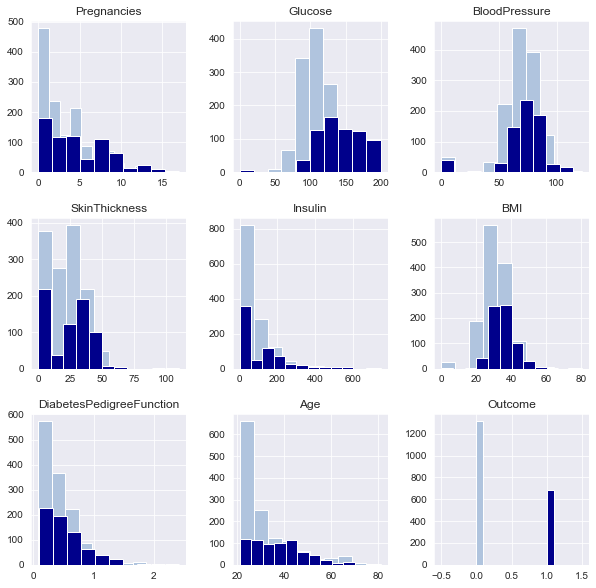

In [24]:
# Variables distribution

positive = diabetes[diabetes['Outcome']==1]
negative = diabetes[diabetes['Outcome']==0]

ax1 = negative.hist(figsize=(10,10), color = "lightsteelblue", label='Overall')
positive.hist(color = "darkblue", ax=ax1, label='Positive')

plt.show()

&nbsp;





Although there are several risk factors related to genetics and lifestyle that have an impact on the chances of developing type 2 diabetes, two of the most commonly mentioned in scientific literature, are the patients' family history of diabetes (indicated in this dataset by the 'Diabetes Pedigree Function' column) and their weight (indicated in this dataset by the 'BMI' column). 'Glucose' may also be one of the most important features for diagnosis, as it could indicate pre-diabetes conditions.
&nbsp;

So I decided to focus on these factors in this section. 
&nbsp;


Since the dataset's sample belongs to a specific group of female patients (for example, also includes the 'Pregnancies' variable), it is important to note that the analysis performed later elucidated whether the feature importance agrees or differs from the aforementioned risk factors.  

&nbsp;



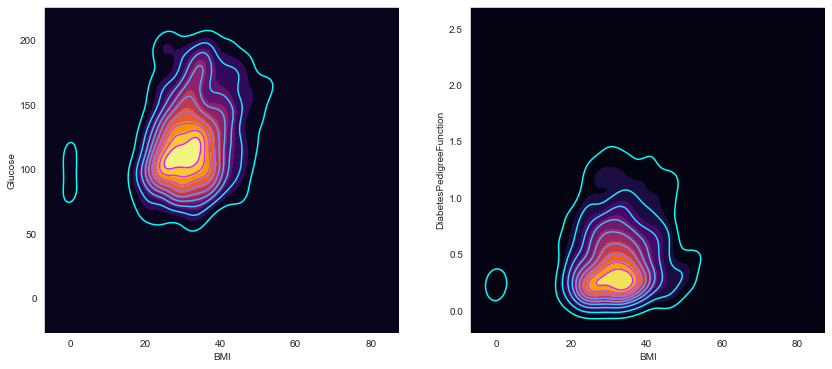

In [15]:
# KDE plots

sns.set_style("darkgrid")
f, axes = plt.subplots(1, 2, figsize=(14,6)) 

p1 = sns.kdeplot(diabetes.BMI, diabetes.Glucose, shade=True,  shade_lowest=True, cmap='inferno', ax=axes[0])
p1b = sns.kdeplot(diabetes.BMI, diabetes.Glucose, cmap='cool', ax=axes[0])


p2 = sns.kdeplot(diabetes.BMI, diabetes.DiabetesPedigreeFunction, shade=True,  shade_lowest=True, cmap='inferno', ax=axes[1])
p2b = sns.kdeplot(diabetes.BMI, diabetes.DiabetesPedigreeFunction, cmap='cool', ax=axes[1])


plt.show()

&nbsp;

The plots above show the distribution of some of the continous attributes in the dataset. According to literature, a BMI of around 25 and higher indicates that the patient is overweight. It can be observed that a large portion of the patients fall into this category and it is at least somewhat positively correlated with high blood sugar (Glucose) and with the genetic predisposition (Predigree Function). 


&nbsp;

**Clustering** is basically the task of identifying subgroups in the data (having similar data points in the same cluster). It is a useful exploratory data analysis technique used to get a meaningful intuition about the structure of the data. 
&nbsp;

In the context of this project, clustering algorithms can help to identify the characteristics of different patient clusters and to gather patients into different subgroups and build a model for a specific subgroup to predict the probability of the risk of disease.


&nbsp;

In the code below, 2 different algorithms were implemented to cluster patients based on their BMI and their blood sugar levels (Glucose). 

In [28]:
# K means clustering

X_kmeans = diabetes.iloc[:, [1,5]].values

**K- means clustering** simply divides the data points of interest into non-overlapping subsets (clusters) such that each data point is in exactly one subset.  It assigns data points to a cluster such that the sum of the squared distance between the data points and the cluster’s centroid (arithmetic mean of all the data points that belong to that cluster) is at the minimum. 


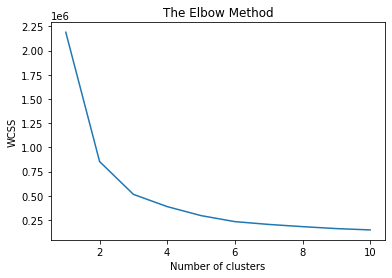

In [29]:
# Using the elbow method to find the optimal number of clusters

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_kmeans)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.show()

It can be observed that the 'elbow' is located on number 3 and after that the WCSS value (within cluster sum of errors) starts dramatically decreasing. **The ideal number of clusters in this case is 3.**

In [30]:
# Training the K-Means model on the dataset

kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X_kmeans)

K-means clustering minimizes within-cluster variances **(squared Euclidean distances)**, but not regular Euclidean distances.

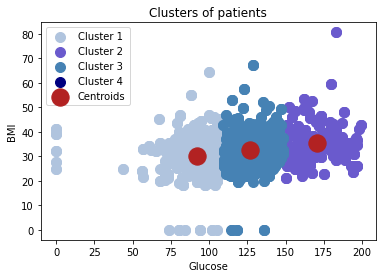

In [32]:
# Visualizing the clusters

plt.scatter(X_kmeans[y_kmeans == 0, 0], X_kmeans[y_kmeans == 0, 1], s = 100, c = 'lightsteelblue', label = 'Cluster 1')
plt.scatter(X_kmeans[y_kmeans == 1, 0], X_kmeans[y_kmeans == 1, 1], s = 100, c = 'slateblue', label = 'Cluster 2')
plt.scatter(X_kmeans[y_kmeans == 2, 0], X_kmeans[y_kmeans == 2, 1], s = 100, c = 'steelblue', label = 'Cluster 3')
plt.scatter(X_kmeans[y_kmeans == 3, 0], X_kmeans[y_kmeans == 3, 1], s = 100, c = 'navy', label = 'Cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'firebrick', label = 'Centroids')
plt.title('Clusters of patients')
plt.xlabel('Glucose')
plt.ylabel('BMI')
plt.legend()

plt.show()


&nbsp;

A **hierarchical clustering** is a set of nested clusters that are arranged as a tree (hierarchy of clusters).

In [24]:
# Hierarchical clustering

X_hier = diabetes.iloc[:, [1,5]].values

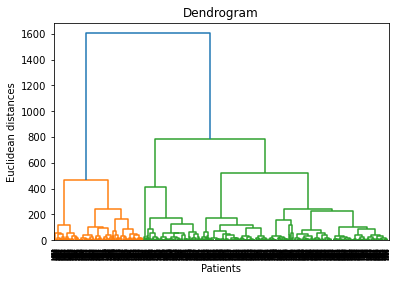

In [25]:
# Using the dendrogram to find the optimal number of clusters

dendrogram = sch.dendrogram(sch.linkage(X_hier, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Patients')
plt.ylabel('Euclidean distances')
plt.show()

&nbsp;

The decision of the number of clusters is decided upon the number of vertical lines in the dendrogram cut by a horizontal line that can transverse the maximum distance vertically without intersecting a cluster. **In this case the ideal number of clusters was 2.**

&nbsp;

In [26]:
# Training the Hierarchical Clustering model 

hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X_hier)

The hierachical clustering strategy of choice was **agglomerative**, a "bottom-up" approach where each observation starts in its own cluster, and pairs of clusters are merged as one moves up the hierarchy.
&nbsp;

The choice of metric will influence the shape of the clusters, as some elements may be relatively closer to one another under one metric than another. In this case, the metric of choice was the **euclidean distance** (distance measure between a pair of samples p and q in an n-dimensional feature space).

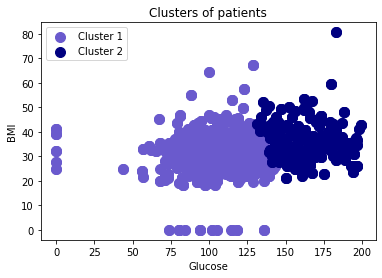

In [27]:
# Visualizing the clusters

plt.scatter(X_hier[y_hc == 0, 0], X_hier[y_hc == 0, 1], s = 100, c = 'slateblue', label = 'Cluster 1')
plt.scatter(X_hier[y_hc == 1, 0], X_hier[y_hc == 1, 1], s = 100, c = 'navy', label = 'Cluster 2')
plt.title('Clusters of patients')
plt.xlabel('Glucose')
plt.ylabel('BMI')
plt.legend()

plt.show()

&nbsp;

The clusters changed in the two plots due to the different metrics implemented by each algorithm. However, in both of them a cluster can be roughly identified: patients with a BMI >= 25 and Glucose >=150. **This could be considered as a high-risk patient subgroup as those measurements indicate possible pre-diabetes conditions and them being overweight** (further investigated in the model fitting section of this notebook).

&nbsp;


## <span style='color:steelblue'> 2. Model fitting </span>

&nbsp;

First of all, SVM was implemented for classification using a matrix of features of all the input variables available in the dataset (for comparison with posterior analysis).


In [28]:
# Support vector classifier using all input variables


# Preprocessing
X = diabetes.loc[:, diabetes.columns != 'Outcome']  # creating matrix of features
y = diabetes.loc[:, 'Outcome']  # dependent variable vector
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)  # data set splitting

# Fitting
svc = svm.SVC(kernel = 'linear', random_state = 0)  
svc.fit(X_train, y_train)  

svc_ypred = svc.predict(X_test)  # computing predictions
svc_acc = round(svc.score(X_test, y_test), 2)
print('Test Accuracy: %.3f' % svc.score(X_test, y_test)) # accuracy

# Cross validation and performance report
scores = cross_val_score(svc, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)
print('Accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Test Accuracy: 0.790
Accuracy: 0.766 +/- 0.032


&nbsp;


Feature importance was plotted below.

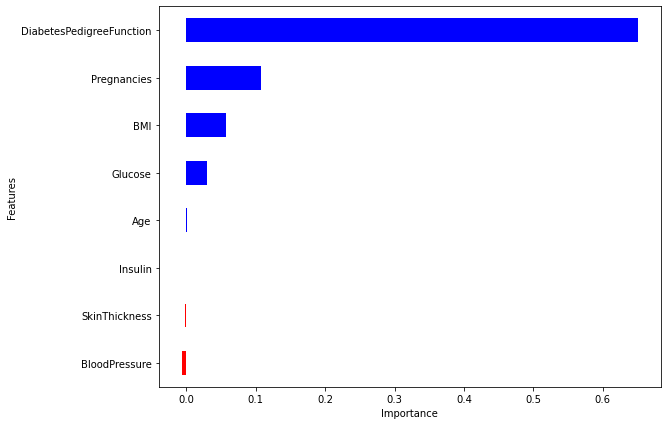

In [29]:
# SVC feature importance plot

coeff = list(svc.coef_[0])
labels = list(X_train.columns)
 
features = pd.DataFrame()
features['Features'] = labels
features['importance'] = coeff
features.sort_values(by=['importance'], ascending=True, inplace=True)
features['positive'] = features['importance'] > 0
features.set_index('Features', inplace=True)
features.importance.plot(kind='barh', figsize=(9, 7),color = features.positive.map({True: 'blue', False: 'red'}))
plt.xlabel('Importance')

plt.show()

&nbsp;

Then SVM was implemented again, this time only considering the top 2 most important features for prediction (plot above), to investigate how much of the prediction could be attributed to just those features.

&nbsp;

In [13]:
# SVC of the top 2 most important features


# Preprocessing
Xb = diabetes.loc[:, ('DiabetesPedigreeFunction','Pregnancies')]  # creating matrix of features
yb = diabetes.loc[:, 'Outcome']  # dependent variable vector
X_trainb, X_testb, y_trainb, y_testb = train_test_split(Xb, yb, test_size=0.2, random_state = 1)  # data set splitting

# Fitting
svc_b = svm.SVC(kernel = 'linear', random_state = 0)  
svc_b.fit(X_trainb, y_trainb)  

svcb_ypred = svc_b.predict(X_testb)  # computing predictions
svcb_acc = round(svc_b.score(X_testb, y_testb), 2)
print('Test Accuracy: %.3f' % svc_b.score(X_testb, y_testb)) # accuracy

# Cross validation and performance report
scores = cross_val_score(svc_b, X_trainb, y_trainb, scoring='accuracy', cv=10, n_jobs=-1)
print('Accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Test Accuracy: 0.672
Accuracy: 0.654 +/- 0.003


&nbsp;

Then, SVM was implemented considering only the BMI and Glucose variables for all patients.

In [30]:
# SVC: BMI + Glucose


# Preprocessing
Xc = diabetes.loc[:, ('BMI','Glucose')]  # creating matrix of features
yc = diabetes.loc[:, 'Outcome']  # dependent variable vector
X_trainc, X_testc, y_trainc, y_testc = train_test_split(Xc, yc, test_size=0.2, random_state = 1)  # data set splitting

# Fitting
svc_c = svm.SVC(kernel = 'linear', random_state = 0)  
svc_c.fit(X_trainc, y_trainc)  

svcc_ypred = svc_c.predict(X_testc)  # computing predictions
svcc_acc = round(svc_c.score(X_testc, y_testc), 2)
print('Test Accuracy: %.3f' % svc_c.score(X_testc, y_testc)) # accuracy

# Cross validation and performance report
scores = cross_val_score(svc_c, X_trainc, y_trainc, scoring='accuracy', cv=10, n_jobs=-1)
print('Accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Test Accuracy: 0.762
Accuracy: 0.749 +/- 0.037


&nbsp;

The decision regions for this model were plotted below.

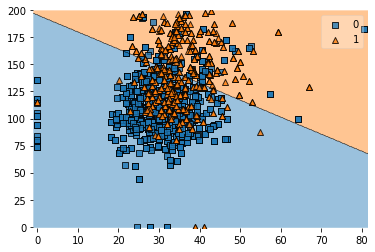

In [31]:
# SVM decision region plot

X_trainc = np.array(X_trainc)
y_trainc = np.array(y_trainc)

plot_decision_regions(X_trainc, y_trainc, clf = svc_c) 

plt.show()

&nbsp;

Finally, the SVM model was also fit to a subset of the original dataset containing only patients of the 'high-risk' subgroup aforementioned (EDA clustering section).

In [9]:
# Filtering data frame according to cluster conditions

diabetes_risk = diabetes.loc[(diabetes['BMI']>=25) & (diabetes['Glucose']>=150)]

In [15]:
# SVC: BMI + Glucose high risk cluster

# Preprocessing
Xd = diabetes_risk.loc[:, ('BMI','Glucose')]  # creating matrix of features
yd = diabetes_risk.loc[:, 'Outcome']  # dependent variable vector
X_traind, X_testd, y_traind, y_testd = train_test_split(Xd, yd, test_size=0.2, random_state = 1)  # data set splitting

# Fitting
svc_d = svm.SVC(kernel = 'linear', random_state = 0)  
svc_d.fit(X_traind, y_traind)  

svcd_ypred = svc_d.predict(X_testd)  # computing predictions
svcd_acc = round(svc_d.score(X_testd, y_testd), 2)
print('Test Accuracy: %.3f' % svc_d.score(X_testd, y_testd)) # accuracy

# Cross validation and performance report
scores = cross_val_score(svc_d, X_traind, y_traind, scoring='accuracy', cv=10, n_jobs=-1)
print('Accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Test Accuracy: 0.811
Accuracy: 0.694 +/- 0.005


In [16]:
# Results table

print(tabulate([['SVC: all features', svc_acc], 
                ['SVC: PedigreeFunction + Pregnancies', svcb_acc], 
                ['SVC: BMI + Glucose', svcc_acc], 
                ['SVC: BMI + Glucose high risk', svcd_acc]]))

-----------------------------------  ----
SVC: all features                    0.79
SVC: PedigreeFunction + Pregnancies  0.67
SVC: BMI + Glucose                   0.76
SVC: BMI + Glucose high risk         0.81
-----------------------------------  ----


&nbsp;

Varying accuracy results were obtained. In comparison with the previous models, the high risk model based only on BMI and Glucose levels achieved the highest accuracy. 